two-phased method

# Set Variables

In [ ]:
# -------- dataset
# software_name = "Camel"
# software_name = "CloudStack"
software_name = "Geode"
# software_name = "Hbase"

knn_accuracy_threshold = [
    0.5, 0.55, 
    0.6, 0.65, 
    0.7, 0.75, 
    0.8, 0.85, 
    0.9, 0.95
]

In [ ]:
if software_name == "Camel":
    dataset_file_name_ts = "Camel_TimeSeries - v.01"

elif software_name == "CloudStack":
    dataset_file_name_ts = "CloudStack_TimeSeries - v.01"

elif software_name == "Geode":
    dataset_file_name_ts = "Geode_TimeSeries - v.01"

else:
    dataset_file_name_ts = "Hbase_TimeSeries - v.03"

# Google Colab

In [ ]:
# Libs
!pip install enlighten
!pip install --upgrade statsmodels 
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# load data from google drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
!ls "/content/gdrive/My Drive/"

Mounted at /content/gdrive
'Colab Notebooks'


In [ ]:
# project folder path
project_folder = "gdrive/MyDrive/Colab Notebooks/paper/"

# data folder path
data_folder = "00- My Data/two-phase method/"

# dataset folder path
dataset_folder = software_name + "/"

# output folder path
output_folder = "01- Jupyter Notebook/80- two-phase method/00. Output/"

# Libs

In [ ]:
import math

import enlighten
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Config

In [ ]:
mypaths = {
    "data": {
        "dataset_timeseries":   project_folder + data_folder   + dataset_folder + dataset_file_name_ts + ".csv"
    },
    "output": {
        "class_predictabality": project_folder + output_folder + dataset_folder + dataset_file_name_ts + "/class-predictabality-v01.csv"
    }
}

preprocessing_params = {
    "data": {
        "dataset_timeseries": {
            # time_stamp is the time that we change the class for a bug fixing.
            # id stands for identifier
            "columns_name":   ["bug_report_id", "class_id", "time_stamp", "label"],
            "columns_dtype" : {0: "int64", 1: "int64", 2: "int64", 3:"int32"}
        },
    },
    "output": {
        "timeseries":{
            "columns_name":   ["class_id", "time_stamp", "label"],
            "columns_dtype" : {0: "int64", 1: "int64", 2:"int32"}
        },
    }
    
    # 0: no change / 1: increase bad smell / -1: decrease bad smell
    "class_labels": [0, 1, -1], 
    "num_classes": 3,
}

knn_model_params = {
    "train_size": 0.8,
    "n_neighbors": 5
}

progress_colours = ["webmaroon", "salmon", "orangered", "deeppink3", "crimson", 
                    "black", "blue", "gray", "cyan4", "darkgreen"]

# Read TimeSeries

In [ ]:
df_timeseries = pd.read_csv(
    mypaths["data"]["dataset_timeseries"], 
    names=preprocessing_params["data"]["dataset_timeseries"]["columns_name"], 
    dtype=preprocessing_params["data"]["dataset_timeseries"]["columns_dtype"], 
    header=None
)

In [ ]:
print(len(df_timeseries))

In [ ]:
df_timeseries_gclass = df_timeseries.groupby("class_id")
classes_list = df_timeseries_gclass.groups.keys()
num_classes = len(classes_list)

In [ ]:
print(type(classes_list))
print("number of classes :", num_classes)

<class 'dict_keys'>
number of classes : 16952


# ProgressLines

In [ ]:
class ProgressLines():
    
    def progress_lines(self, num, total, description, unit, colour):
        desc = self.set_strings_to_equal_len_(description)
        manager = enlighten.get_manager()
        progresses = []
        for i in range(num):
            prog = manager.counter(total=total[i], desc=desc[i], unit=unit[i], color=colour[i])
            prog.refresh()
            progresses.append(prog)
        self.progresses = progresses
    
    
    def set_strings_to_equal_len_(self, description):
        max_len = 0
        longest_string_length = len(max(description, key=len))
        w = []
        for i, word in enumerate(description):
            temp = longest_string_length - len(word)
            w.append(word + " " * temp)
        return w

# MyTimeSer

In [ ]:
class MyTimeSer():

    def __init__(self, df_timeseries_gclass, knn_model_params, threshold):
        self.gdf = df_timeseries_gclass
        self.accepted_num = {"isctss": 0}
        self.threshold = threshold # [0.5, 0.55, ...]
        self.knn_model_params = knn_model_params
        self.time_to_train = None
        self.per_class_predictable = {} # {0.5: 90, 0.55: 70, ...}

        columns_name = ["class_id"]
        columns_dtype = ["int64"]
        temp = {}
        for cn, cd in zip(columns_name, columns_dtype):
            temp[cn] = pd.Series(dtype=cd)
        self.class_pred = pd.DataFrame(temp)
        self.class_pred["class_id"] = self.gdf.groups.keys()


        for th in threshold:
            # add prediction columns
            new_column_name = self.prediction_column_name(th)
            self.class_pred[new_column_name] = np.nan
            self.accepted_num[th] = 0
    

    # ************************** helper ************************** #
    
    def prediction_column_name(self, th):
        return "predictions_" + str(th)
    

    # ************************** prediction ************************** #

    def make_predictions(self):
        # --- ProgressLines
        self.pl = ProgressLines()
        self.pl.progress_lines(1, [len(self.class_pred)], ["time-series-prediction"], ["sample"], ["blue"])

        # --- make prediction
        self.gdf.apply(lambda g: self.flow_(g))
        

        # --- time to train
        totalSeconds = self.progress.elapsed
        hours = int(totalSeconds / 3600)
        minutes = int((totalSeconds - (hours * 3600)) / 60)
        seconds = int((totalSeconds - (hours * 3600 + minutes * 60)))
        self.time_to_train = f"{hours}h:{minutes}m:{seconds}s"
    

    def flow_(self, g):

        # --- extract class time series.
        sorted_df_cts = g.sort_values(by="time_stamp", ascending=True)
        cts = sorted_df_cts["label"].to_numpy()
        
        # --- if cts is stationary, then make prediction & if accuracy pass the threshold, save the prediction
        is_cts_stationary = self.testSeries_(cts)
        if is_cts_stationary:
            self.accepted_num["isctss"] += 1
            accuracy, yhat = self.predictValue_(cts)
            for th in self.threshold:
                if accuracy > th:
                    self.accepted_num[th] += 1
                    tempColumnName = self.prediction_column_name(th)
                    self.class_pred.loc[self.class_pred["class_id"] == g.name, tempColumnName] = int(yhat)
        
        self.pl.progresses[0].update()
    

    def testSeries_(self, cts):
        if len(cts) <= 10:
            return False
        
        result = adfuller(cts)
        critical_values = result[4].items()
        is_cts_stationary = True
        
        for alpha, critical_value in critical_values:
            ADF_Statistic = result[0]
            if critical_value < ADF_Statistic:
                is_cts_stationary = False
                break
        return is_cts_stationary
    
    
    def predictValue_(self, cts):
        max_accuracy = -1
        best_yhat = -1
        for query_length in range(3, 10):
            knnX, knnY = self.knnDS_(cts, query_length)
            query = np.array(cts[-query_length:])
            accuracy, yhat = self.knnPredict_(knnX, knnY, query)
            if accuracy > max_accuracy:
                max_accuracy = accuracy
                best_yhat = yhat
        return (max_accuracy, best_yhat)
    
    
    def knnDS_(self, cts, ql):
        knnX = [cts[i: i + ql] for i in range(len(cts) - ql)] # [[0, -1, 1, 1, ...], [1, 0, 0, 0, ...]]
        knnY = [cts[i + ql]    for i in range(len(cts) - ql)] # [0, 1, ...]
        return knnX, knnY
    
    
    # x: [[0, -1, 1, 1, ...], [1, 0, 0, 0, ...]]
    # y: [0, 1, ...]
    def knnPredict_(self, x, y, query):
        # --- prepare train and test data
        size = int(len(x) * self.knn_model_params["train_size"])
        xtrain, xtest = x[0: size], x[size:]
        ytrain, ytest = y[0: size], y[size:]
        
        if len(xtrain) < 6:
            return 0, 0
        
        # --- train model
        knn = KNeighborsClassifier(n_neighbors=self.knn_model_params["n_neighbors"])
        knn.fit(xtrain, ytrain)
        
        # --- test the model
        accuracy = knn.score(xtest, ytest)
        
        # --- make prediction
        yhat = 0
        query = query.reshape(1, -1)
        yhat = knn.predict(query)
        return accuracy, yhat
    

    def perc_predictable(self):
        num_total = len(self.class_pred)
        temp = []
        for th in self.threshold:
            new_column_name = self.prediction_column_name(th)
            temp2 = num_total - self.class_pred[new_column_name].isna().sum()
            temp3 = round((temp2 / num_total) * 100)
            temp.append(temp3)

        #temp2 = num_total
        self.per_class_predictable = temp
        #numNan = g.iloc[:, -1].isna().sum()
        

    def plotm(self, colours):
        # figsize=(a, b) : a_width, b_height
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
        axes.plot(self.threshold, self.per_class_predictable, label="kl", color="blue", 
                  linestyle="solid", lw=1, marker=".")

        axes.set_title(software_name)
        axes.set_xlabel("KNN threshold accuracy")
        axes.set_ylabel("percentage of pridictable classes")

        axes.set_xlim([0.45, 1.05])
        axes.get_xaxis().set_ticks(self.threshold)

        axes.set_ylim([0, 110])
        axes.get_yaxis().set_ticks(list(range(0, 101, 10)))

        axes.legend()
        axes.grid(True)

    
    def free_memory(self):
        self.df_timeserAll = None

## obj

In [ ]:
mt_data = MyTimeSer(
    df_timeseries_gclass, 
    knn_model_params, 
    knn_accuracy_threshold
)

In [ ]:
print(len(mt_data.class_pred))
mt_data.class_pred.dtypes

16952


class_id              int64
predictions_0.5     float64
predictions_0.55    float64
predictions_0.6     float64
predictions_0.65    float64
predictions_0.7     float64
predictions_0.75    float64
predictions_0.8     float64
predictions_0.85    float64
predictions_0.9     float64
predictions_0.95    float64
dtype: object

In [ ]:
mt_data.progress_lines(progress_colours)
mt_data.make_predictions()

In [ ]:
mt_data.perc_predictable()

In [ ]:
print("number of classes :", len(mt_data.class_pred))
print("percentage of pridictable classes in eahc th :", mt_data.per_class_predictable)

number of classes : 16952
percentage of pridictable classes in eahc th : [46, 46, 45, 45, 44, 43, 42, 41, 39, 38]


# Plot

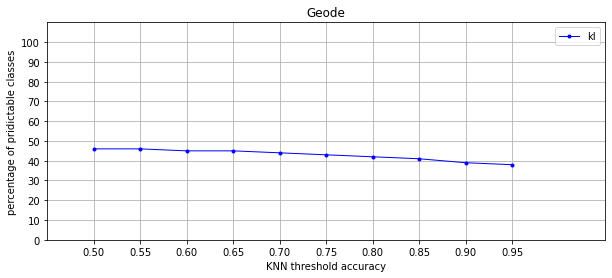

In [ ]:
mt_data.plotm(progress_colours)

# Save

In [ ]:
mt_data.class_pred.to_csv(mypaths["output"]["class_predictabality"], index=False, na_rep="NULL")